# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
Task: In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Writeup and Submission

Description of the resulting pipeline is discussed in [writeup_template.md](writeup_template.md)

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0, 255], thickness=6):
    for line in lines:
        if len(line[0]) == 4:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        elif len(line[0]) == 6:
            for x1,y1,x2,y2,x3,y3 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                cv2.line(img, (x2, y2), (x3, y3), [0, 255, 0, 125], 4)
        else:
            assert(False)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(initial_img, img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Actual implementation - test single images

I created my implementation by exposing most of the important parameter in a signle function and using Jupyter `interact` to hand-tune those parameters on the sample images first. 

<function __main__.detect_lanes_fn(image_fn='', draw_averaged_lanes=True, debug=False, blur_type='bilateral', b_kernel_size=5, b_color_kernel_size=9, canny_low_threshold=120, canny_high_threshold=200, hough_rho=1, hough_theta=2, hough_threshold=20, hough_min_line_len=15, hough_max_line_gap=15, dbscan_eps=0.2, dbscan_min_samples=3)>

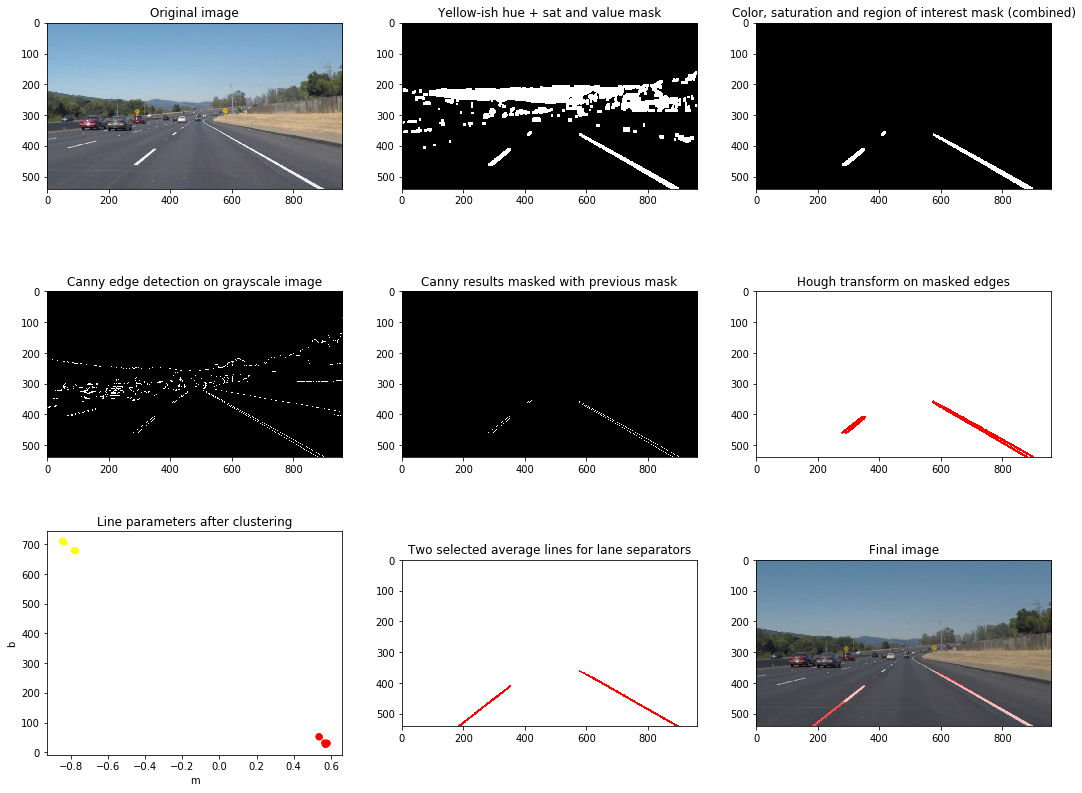

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
from numpy.polynomial import Polynomial
import logging
import functools
import warnings

def hsv(img):
    """
    Convert RGB to HSV
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def hsv_filter(img, hlow, hhigh, slow, shigh, vlow, vhigh):
    """
    Filter an image based on its HSV values and apply slight morphological opening and closing
    to reduce the noise.
    """
    img = cv2.inRange(img, np.array([hlow, slow, vlow]), np.array([hhigh, shigh, vhigh]))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3, 3),np.uint8))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3, 3) ,np.uint8))
    return img

def variable_blur(img, blur_type, kernel_size, color_kernel_size):
    if blur_type == 'gaussian':
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    elif blur_type == 'bilateral':
        return cv2.bilateralFilter(img, d=-1, sigmaColor=color_kernel_size, sigmaSpace=kernel_size)
    else:
        assert False

def hough_lines_filter(img, rho, theta, threshold, min_line_len, max_line_gap, 
                      dbscan_eps, dbscan_min_samples):
    """
    Given an image of edge points, return 
    """
    # Get lines (line segments) from the Hough transform
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # Calculate the line parameters for each line segment - this will be used for clustering.
    # On top of the line parameters m and b, a third boolean value is also added which denotes whether the
    # center of the given line segment is in the left or right side of the image. This was introduced
    # because sometimes false detections (mostly cars) from the other side of the image were grouped 
    # together with the points of a lane, causing the final line to be drawn way too long. This new parameter
    # helped DBSCAN to not group these together (though this is not explicitly prohibited).
    line_parameters = []
    y_size, x_size = img.shape
    for line in lines:
        x0, y0, x1, y1 = line[0]
        if x0 == x1:
            # I know, I should have used the other parametrization for the lanes.. but I am almost 
            # ready and too lazy to rewrite everything
            m = 10e5
        else:
            m = (y1 - y0)/(x1 - x0)
        b = y0 - m*x0
        is_left = ((x0 + x1) / 2 < x_size / 2) * 1
        line_parameters.append((m, b, is_left))

    line_parameters = np.array(line_parameters)

    # Perform cluseting on the line segments using DBSCAN
    X = StandardScaler().fit_transform(line_parameters)    
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    unique, counts = np.unique(labels, return_counts=True)
    line_groups = np.asarray((unique, counts)).T
    line_groups = line_groups[line_groups[:, 0] != -1] # -1 is used for ungrouped lines by DBSCAN, ignore those
    
    def get_line_group_parameters(label, lines, line_parameters):
        """
        Get a single set of parameters for each line group clustered by DBSCAN
        """
        # Select the line that belong to the group denoted by label.
        # DBSCAN returns 'core samples' and 'adjacent samples'. Core samples are the ones that
        # are close to each other and represent the group, the other ones are further away.
        # Only core samples are included here in the calculation, hoping that it improves the
        # robustness of the results. I could have also included non-core samples with a lower
        # weight in fitting.
        mask = (labels == label) & (core_samples_mask == True)
        current_line_parameters = line_parameters[mask]
        line_parts = lines[mask]
        
        # Originally I calculated line group parameters by taking the mean of the individual lines..
        #line_m_mean = np.mean(current_line_parameters[:, 0])
        #line_b_mean = np.mean(current_line_parameters[:, 1])

        # ..but then I turned to fitting a new line to all the original points instead
        coords = line_parts.flatten()
        x_coords = coords[::2]
        y_coords = coords[1::2]
        p = Polynomial.fit(x_coords, y_coords, deg=1)
        coeffs = p.convert(domain=(-1,1))
        try:
            line_b, line_m = coeffs
        except:
            # numpy returns differently shaped coefficients if m == 0.0.. that's very unkind
            line_b = coeffs.coef[0]
            line_m = 0
        
        # Calculate the x for which the lowest y value is given by any of the line segments
        # that belong to the line. Essentially this is the furthest point of the line group that 
        # was detected. This will be used during plotting as the final point drawn on the plot,
        # to avoid drawing crossing lines.
        line_min_y = line_parts[:, :, [1, 3]].min().min()
        if line_m != 0.0:
            line_x_for_min_y = int((line_min_y - line_b) / line_m)
        else:
            line_x_for_min_y = 0 # no really good solution here
        
        return line_m, line_b, line_x_for_min_y
    
    # Calculate parameters for all line groups and add them to the original information
    unique_label_parameters = []
    for row in line_groups:
        label = row[0]
        m, b, x_for_min_y = get_line_group_parameters(label, lines, line_parameters)
        is_valid = label != -1 and abs(m) > 0.3
        unique_label_parameters.append([is_valid, m, b, x_for_min_y])
    line_groups = np.hstack([line_groups, unique_label_parameters])
    line_groups = line_groups[np.lexsort((line_groups[:, 1], line_groups[:, 2] * -1))]

    return lines, line_parameters, labels, line_groups
    

def detect_lanes(image, draw_averaged_lanes=True, debug=False, 
                 blur_type='bilateral', b_kernel_size=5, b_color_kernel_size=9, 
                 canny_low_threshold=120, canny_high_threshold=200,
                 hough_rho=1, hough_theta=2, hough_threshold=10, hough_min_line_len=10, hough_max_line_gap=15,
                 dbscan_eps=0.20, dbscan_min_samples=3):
    """
    Given a color image return the same image with the detected lanes drawn as an overlay.
    This is the main function of the solution.
    
    All parameters not listed in the docstring are used by one of the image processing steps. They are added
    to this function so that they can be interactively modified using `interact`.
    
    :param draw_averaged_lanes: If False then all segmented edge points of the line separators are drawn. 
        If True then a single average line is drawn for both lane separators, unless those could not be
        calculated, in which case it falls back on the segmented output.
    :param debug: If True then many subplots are drawn showing intermediate steps, and no image is returned - 
        this is used when using `interact`. If False then no plots are drawn and a single image is returned,
        which is used when generating the videos.
    """
    hough_theta = math.pi/180 * hough_theta
    
    if debug:
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
    
    y, x, c = image.shape
    if debug:
        ax[0][0].imshow(image)
        ax[0][0].set_title("Original image")
    
    # Create a mask based on color and region of interest
    hsv_img = hsv(image)
    # Color mask selecting mostly yellow lanes and some green vegetation
    h_mask_img = hsv_filter(hsv_img, 20, 60, 0, 255, 100, 255)
    # Color mask selecting bright areas, regardless or color
    sv_mask_img = hsv_filter(hsv_img, 0, 180, 0, 50, 180, 255)
    # Combine and dilate the mask in order to avoid dropping points later in case the edge detector 
    # finds values just outside these masks
    mask_img = cv2.dilate(cv2.bitwise_or(h_mask_img, sv_mask_img), np.ones((7, 5),np.uint8), iterations=1)
    if debug:
        ax[0][1].imshow(mask_img, cmap='gray')
        ax[0][1].set_title("Yellow-ish hue + sat and value mask")
    # Add region of interest mask
    roi_points = np.array([[[0, y], [x/2-10, y/2+50], [x/2+10, y/2+50], [x, y], [0, y]]], dtype=np.int32)
    mask_img = region_of_interest(mask_img, roi_points)
    if debug:
        ax[0][2].imshow(mask_img, cmap='gray')
        ax[0][2].set_title("Color, saturation and region of interest mask (combined)")
    
    # Convert to grayscale
    gray_img = grayscale(image)
    # Apply blur before Canny
    blur_img = variable_blur(gray_img, blur_type, b_kernel_size, b_color_kernel_size)
    #ax[1].imshow(blur_img, cmap='gray')
    # Edge detection
    canny_img = canny(blur_img, canny_low_threshold, canny_high_threshold)
    if debug:
        ax[1][0].imshow(canny_img, cmap='gray')
        ax[1][0].set_title("Canny edge detection on grayscale image")

    # Apply mask
    masked_img = cv2.bitwise_and(canny_img, canny_img, mask=mask_img)
    if debug:
        ax[1][1].imshow(masked_img, cmap='gray')
        ax[1][1].set_title("Canny results masked with previous mask")
    
    # Hough transform, clustering of lines and calculation of combined lines
    lines, line_parameters, labels, line_groups = hough_lines_filter(
            masked_img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap,
            dbscan_eps, dbscan_min_samples)
    
    # Draw the results of the Hough transform
    hough_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    draw_lines(hough_img, lines)
    if debug:
        ax[1][2].imshow(hough_img)
        ax[1][2].set_title("Hough transform on masked edges")
        
    # Draw the line parameters and the results of the clustering
    if debug:
        norm = colors.Normalize(vmin=min(labels), vmax=max(labels))
        group_colors = cm.autumn(norm(labels).tolist())
        ax[2][0].scatter(line_parameters[:, 0], line_parameters[:, 1], c=group_colors)
        ax[2][0].set_title("Line parameters after clustering")
        ax[2][0].set_xlabel("m")
        ax[2][0].set_ylabel("b")
    
    def get_selected_lanes(line_groups):
        """
        Get the two selected average lines if possible.
        The selected left and right lanes are the ones with the largest/smallest b values,
        which is a rough approximation for the lanes crossing x=0 closest to the center of the image
        """
        if line_groups is None:
            return None, None
        line_groups = line_groups[line_groups[:, 2] > 0]
        if len(line_groups) == 0:
            return None, None
        left_lane, right_lane = None, None
        left_lanes = line_groups[line_groups[:, 3] < 0]
        if len(left_lanes) > 0:
            left_lane = left_lanes[np.argmax(left_lanes[:, 4])]
        right_lanes = line_groups[line_groups[:, 3] > 0]
        if len(right_lanes) > 0:
            right_lane = right_lanes[np.argmin(right_lanes[:, 4])]

        return left_lane, right_lane
    
    # Select the final left and right lanes
    left_lane, right_lane = get_selected_lanes(line_groups)
    if left_lane is not None and right_lane is not None:
        hough_img_combinedlines = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
        def draw_points_for_combined_lane(lane_m, lane_b, lane_x_for_min_y):
            if lane_m < 0:
                return [0, int(lane_m * 0 + lane_b), int(lane_x_for_min_y), int(lane_m * lane_x_for_min_y + lane_b)]
            else:
                return [int(x), int(lane_m * x + lane_b), int(lane_x_for_min_y), int(lane_m * lane_x_for_min_y + lane_b)]
        full_lines = np.array([[draw_points_for_combined_lane(left_lane[3], left_lane[4], left_lane[5]), 
                                draw_points_for_combined_lane(right_lane[3], right_lane[4], right_lane[5])]])
        draw_lines(hough_img_combinedlines, full_lines)
        hough_img_combinedlines = region_of_interest(hough_img_combinedlines, roi_points)
        if debug:
            ax[2][1].imshow(hough_img_combinedlines)
            ax[2][1].set_title("Two selected average lines for lane separators")
    else:
        hough_img_combinedlines = hough_img
    
    result = hough_img_combinedlines if draw_averaged_lanes else hough_img
    # Apply result - drawLines has been modified to draw with an alpha channel to make results nicer
    result = cv2.cvtColor(weighted_img(cv2.cvtColor(image, cv2.COLOR_RGB2RGBA), 
                                       result, 0.8, 1.0), cv2.COLOR_RGBA2RGB)
    if debug:
        ax[2][2].imshow(result)
        ax[2][2].set_title("Final image")
    
    if not debug:
        return result

    
def detect_lanes_fn(image_fn='', draw_averaged_lanes=True, debug=False, 
                    blur_type='bilateral', b_kernel_size=5, b_color_kernel_size=9, 
                    canny_low_threshold=120, canny_high_threshold=200,
                    hough_rho=1, hough_theta=2, hough_threshold=20, hough_min_line_len=15, hough_max_line_gap=15,
                    dbscan_eps=0.20, dbscan_min_samples=3):
    warnings.simplefilter("error")
    # Read image
    image = mpimg.imread("test_images/{}".format(image_fn))
    
    result = detect_lanes(image, draw_averaged_lanes=draw_averaged_lanes, debug=debug, 
                          blur_type=blur_type,
                          b_kernel_size=b_kernel_size, 
                          canny_low_threshold=canny_low_threshold, canny_high_threshold=canny_high_threshold,
                          hough_rho=hough_rho, hough_theta=hough_theta, 
                          hough_threshold=hough_threshold, hough_min_line_len=hough_min_line_len, 
                          hough_max_line_gap=hough_max_line_gap,
                          dbscan_eps=dbscan_eps, dbscan_min_samples=dbscan_min_samples)
    
    if not debug:
        return image, result

interact(detect_lanes_fn,
         draw_averaged_lanes=True,
         debug=fixed(True),
         image_fn=os.listdir("test_images/"),
         blur_type=['gaussian', 'bilateral'],
         b_kernel_size=(3, 13, 2),
         b_color_kernel_size=(3, 13, 2), # only for bilateral filtering
         canny_low_threshold=(0, 255, 5),
         canny_high_threshold=(0, 255, 5),
         hough_rho=(1, 10),
         hough_theta=(0.1, 20),
         hough_threshold=(1, 100, 5),
         hough_min_line_len=(1, 200, 5),
         hough_max_line_gap=(0, 200, 5),
         dbscan_eps=(0, 1.0, 0.05),
         dbscan_min_samples=(1, 20))

## Plotting all test images

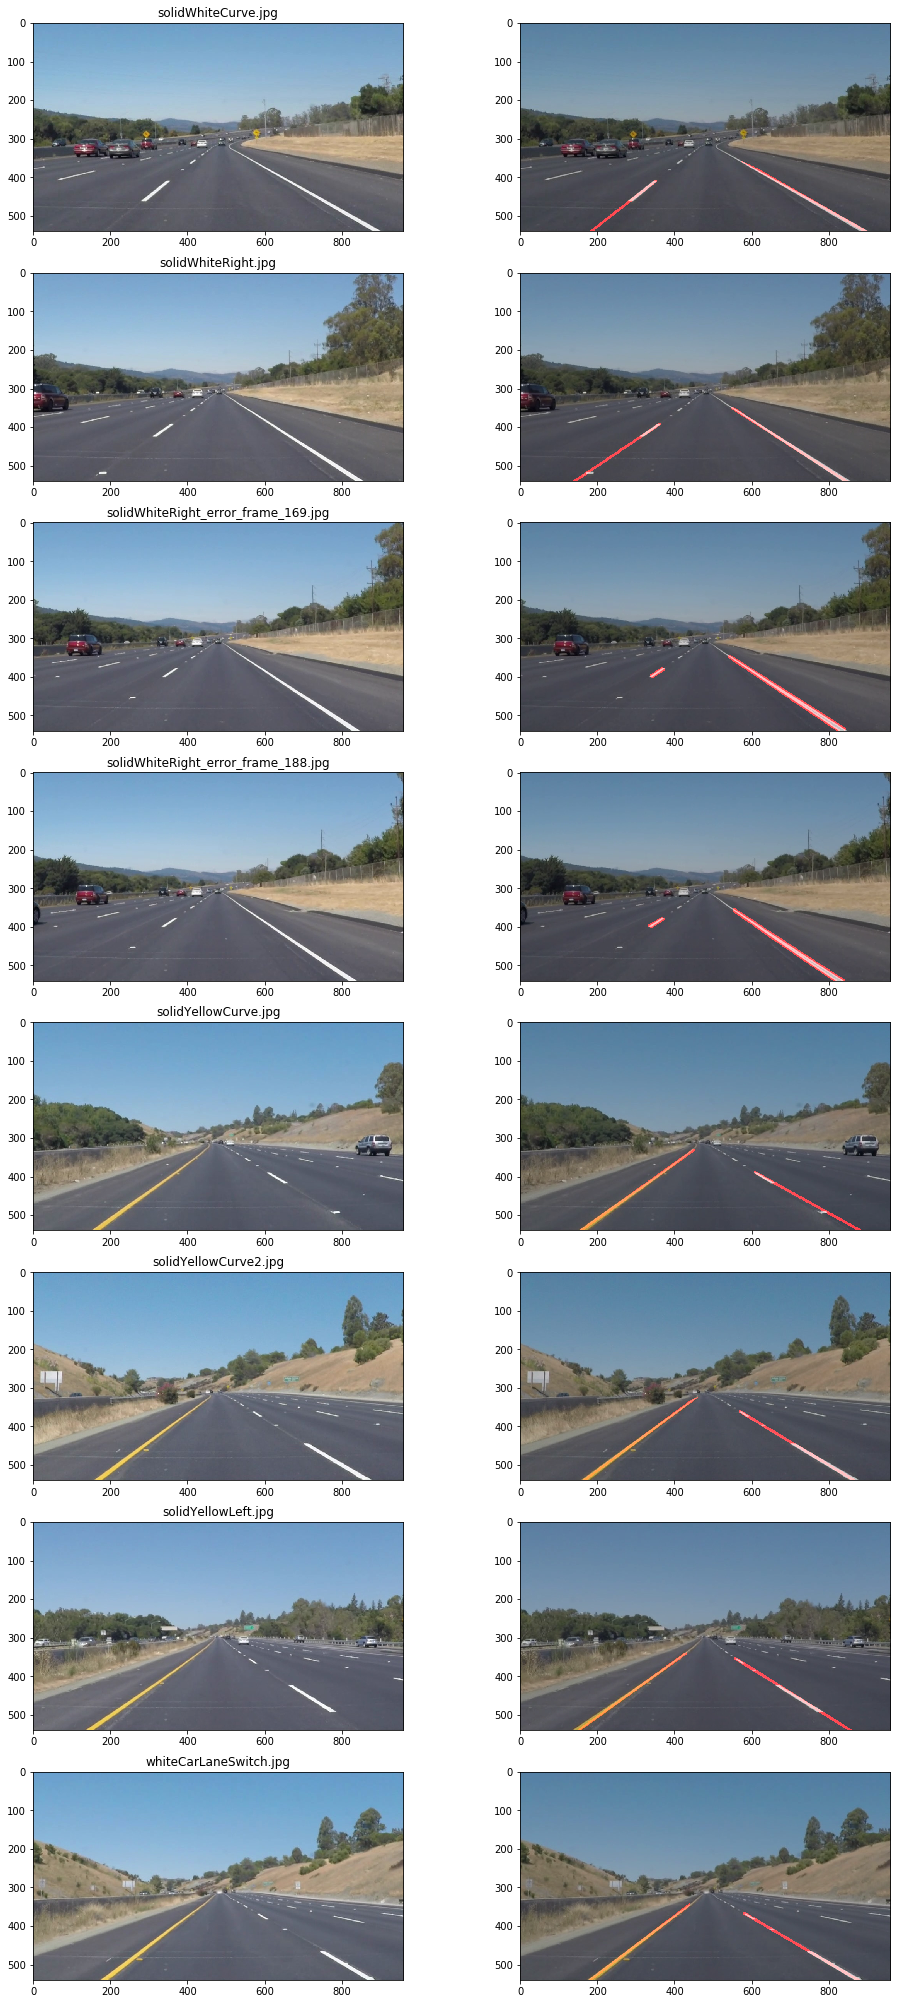

In [4]:
image_fns = os.listdir("test_images/")

fig, ax = plt.subplots(nrows=len(image_fns), ncols=2, figsize=(16, 36))
for index, image_fn in enumerate(image_fns):
    
    image, result_image = detect_lanes_fn(image_fn=image_fn, debug=False)

    if not os.path.exists("test_images_output"):
        os.makedirs("test_images_output")
    mpimg.imsave("test_images_output/{}".format(image_fn), result_image)
    
    ax[index][0].set_title(image_fn)
    ax[index][0].imshow(image)
    ax[index][1].imshow(result_image)

## Test on Videos - draw segmentation patches over each lane separator segment

In [5]:
global frame_id
frame_id = 0
def process_image_variable(image, draw_averaged_lanes, video_fn, save_every_nth_frame=None):
    global frame_id
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            result = detect_lanes(image, draw_averaged_lanes=draw_averaged_lanes)
    except:    
        logging.error("Error happened while processing frame {}, saving it for debugging.".format(frame_id))
        # save erroneous frames from the video for easier debugging
        mpimg.imsave("test_images/{}_error_frame_{}.jpg".format(video_fn, frame_id), image)
        result = image
    
    if save_every_nth_frame and frame_id % save_every_nth_frame == 0:
        mpimg.imsave("test_images/{}_frame_{}.jpg".format(video_fn, frame_id), image)
        
    frame_id += 1
    
    return result

# Pass to the video functions using a partial, e.g.
process_image = functools.partial(process_image_variable, draw_averaged_lanes=False, video_fn='video.mp4')

Let's try the one with the solid white lane on the right first ...

In [6]:
video_fn = 'solidWhiteRight'
white_output = 'test_videos_output/{}.mp4'.format(video_fn)
clip1 = VideoFileClip("test_videos/{}.mp4".format(video_fn))
process_image = functools.partial(process_image_variable, draw_averaged_lanes=False, video_fn=video_fn)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [7]:
# Gif output for the readme
# white_clip.subclip(1, 4).write_videofile("test_videos_output/{}.gif".format(video_fn), audio=False, codec='gif', fps=15)

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Draw a single line per lane separator instead of the segmentation result

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
video_fn = 'solidYellowLeft.mp4'
yellow_output = 'test_videos_output/{}'.format(video_fn)
clip2 = VideoFileClip('test_videos/{}'.format(video_fn))
process_image = functools.partial(process_image_variable, draw_averaged_lanes=True, video_fn=video_fn)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
video_fn = 'challenge.mp4'
challenge_output = 'test_videos_output/{}'.format(video_fn)
clip3 = VideoFileClip('test_videos/{}'.format(video_fn))
process_image = functools.partial(process_image_variable, draw_averaged_lanes=True, video_fn=video_fn)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))